#### using the synthetic data from Misha. Quick validating of Unet

In [1]:
!pip install mrcfile

In [2]:
# data loading
import os
import mrcfile
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from tqdm import tqdm  # ! this might result into problem with 'object'

In [3]:
def readMRC(path):
    with mrcfile.open(path, mode='r+', permissive=True) as mrc:
        mrc.header.map = mrcfile.constants.MAP_ID # for synthetic data, need to generate ID
        data = mrc.data
    return data

In [4]:
DATA_PATH = 'F:/MDC/4.1dataAugNeat/EM/3dem/data/interim/synthetic/'
data_ids = next(os.walk(DATA_PATH))[1]

In [5]:
import os
import pandas as pd
raw = []
for n, id_ in tqdm(enumerate(data_ids), total=len(data_ids)):  
    path = DATA_PATH + id_
    datanames = os.listdir(path)
    for dataname in datanames:
        if os.path.splitext(dataname)[1] == '.mrc': # all .mrc under the path
            temp = readMRC(path + "/" + dataname).astype(np.uint8)
            raw.append(temp)
            print(dataname)
            
focal = raw[0:3]
GT = raw[3:len(raw)]
del raw, temp, datanames, dataname, path, data_ids, n, id_

  0%|                                                                                            | 0/2 [00:00<?, ?it/s]E:\INSTALL\anaconda\envs\seg\lib\site-packages\mrcfile\mrcinterpreter.py:219: RuntimeWarning: Unrecognised machine stamp: 0x00 0x00 0x00 0x00
  warnings.warn(str(err), RuntimeWarning)
 50%|██████████████████████████████████████████                                          | 1/2 [00:00<00:00,  7.43it/s]

tomo1_focalseries.mrc
tomo2_focalseries.mrc
tomo3_focalseries.mrc
tomo1_groundtruth.mrc


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  5.38it/s]

tomo2_groundtruth.mrc
tomo3_groundtruth.mrc


uint8


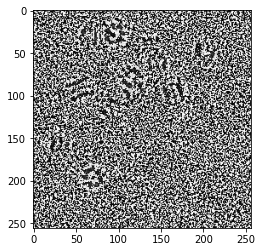

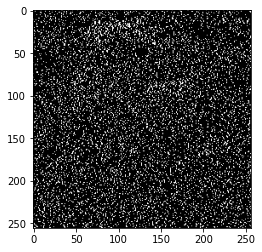

In [6]:
# sanity check for the data
import random
testF = focal[0]
testF.shape

testIm = testF[random.randint(0, testF.shape[0]),...]
print(testF.dtype)
plt.figure('focal');plt.imshow(testIm, cmap='gray')

testGT = GT[0]
testGT.shape

testIm = testGT[random.randint(0,testGT.shape[0]),...]
plt.figure();plt.imshow(testIm, cmap='gray')

In [7]:
# training dataset raw
# select the firt two (focal+ GT) as training, third as testing
import torchio as tio
from patchify import patchify, unpatchify

train_raw = np.vstack(([focal[0], focal[1]]));train = train_raw[...,np.newaxis].transpose((3,1,2,0)); label = np.vstack(([GT[0], GT[1]]))#;label = train_label[...,np.newaxis]
# print(train_raw.shape)
# padding into the same size
trainIO = tio.ScalarImage(tensor=train)
target_shape = 256,256,512
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(trainIO) # padding with mean
train_padd = resized.numpy().transpose((3,1,2,0)); train_padd = train_padd[...,0]
print(train_padd.shape);print(label.shape)

(512, 256, 256)
(512, 256, 256)


In [8]:
# testing dataset raw
X_test = focal[2]; X_test = X_test[...,np.newaxis].transpose((3,1,2,0))
Y_test_label = GT[2]; Y_test_label = (Y_test_label > 0.5).astype(np.float) 

testIO = tio.ScalarImage(tensor=X_test)
target_shape = 256,256,256
crop_pad = tio.CropOrPad(target_shape, padding_mode='mean'); resized = crop_pad(testIO)
test_padd = resized.numpy().transpose((3,1,2,0)); test_padd = test_padd[...,0];
print(test_padd.shape);print(Y_test_label.shape)

E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until


(256, 256, 256)
(256, 256, 256)


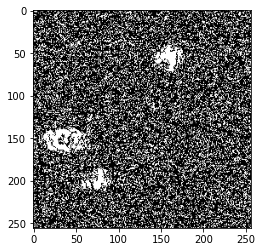

In [9]:
# sanity check
test = Y_test_label[100,...]
plt.imshow(test,cmap='gray')

In [10]:
# patchify the images
def rawPatch(imageStack,patchPara):
    all_img_patches = []

    for img in range(imageStack.shape[0]):
        large_image = imageStack[img]

        patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])  # no overlap

        for i in range(patches_img.shape[0]):
            for j in range(patches_img.shape[1]):

                single_patch_img = patches_img[i,j,:,:]
                single_patch_img = (single_patch_img.astype('float32')) / 255.  # remember to standarize into 0-1

                all_img_patches.append(single_patch_img)
    
    return all_img_patches, patches_img.shape
    

In [11]:
# train dataset
patchPara = {'x': 128, 'y': 128, 'step':128}
Xtrain_patches, _ = rawPatch(train_padd, patchPara);Xtrain_patches = np.stack((Xtrain_patches,)*3, axis=-1) # dock 3 times, the model expects 3 channel
# print(Xtrain_patches.shape)

Ytrain_patches, _ = rawPatch(label, patchPara);Ytrain_patches = np.expand_dims(Ytrain_patches, -1)
Ytrain_patches = (Ytrain_patches > 0.5).astype(np.float) # binarize the data

# test dataset
Xtest_patches, patchSize = rawPatch(test_padd, patchPara);Xtest_patches = np.stack((Xtest_patches,)*3, axis=-1)
Ytest_patches, _ = rawPatch(Y_test_label, patchPara);Ytest_patches = np.expand_dims(Ytest_patches, -1)
Ytest_patches = (Ytest_patches > 0.5).astype(np.float)
print(Xtest_patches.shape);print(Ytest_patches.shape)

E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys


(1024, 128, 128, 3)
(1024, 128, 128, 1)


E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [12]:
# # 检查重构
# patchPara = {'x': 128, 'y': 128, 'step':128}
# testStack = test_padd # 没有复制成为三通道之前
# one_img_patches = []
# large_image = testStack[0]
# print(large_image.shape)
# patches_img = patchify(large_image, (patchPara['x'],patchPara['y']), step=patchPara['step'])
# print(patches_img.shape)

# for i in range(patches_img.shape[0]):
#     for j in range(patches_img.shape[1]):
#         single_patch_img = patches_img[i,j,:,:]
#         one_img_patches.append(single_patch_img)
    
# from patchify import unpatchify
# test = np.array(one_img_patches)
# print(test.shape)
# test1 = np.reshape(test, (2,2,128,128))
# print(test1.shape)
# test2 = unpatchify(test1, large_image.shape)   

# # show the unpatchified files
# plt.imshow(large_image,cmap='gray')
# plt.figure();plt.imshow(test2, cmap='gray')

# # 检查patches里面的内容
# # patches里面是正常的序列
# patch_test = Xtest_patches[0:4]; patch_test = patch_test[...,0]
# print(patch_test.shape)
# test3 = np.reshape(patch_test, (2,2,128,128))
# test4 = unpatchify(test3, large_image.shape)
# plt.figure();plt.imshow(test4, cmap='gray')

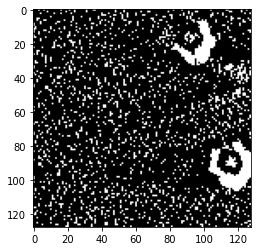

In [13]:
plt.imshow(Ytrain_patches[700],cmap='gray')

In [14]:
# define the parameters of images
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [15]:
# generating the model on our own
import tensorflow.keras as k

inputs = k.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

s = k.layers.Lambda(lambda x: x)(inputs)  # transfer the data into float ! sometimes here should be divded with 255
c1 = k.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(s)  # kernel_init initilaize the parameters
c1 = k.layers.Dropout(0.1)(c1)
c1 = k.layers.Conv2D(16, (3,3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = k.layers.MaxPooling2D((2,2))(c1)

# c1 - c5 are contraction paths
c2 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = k.layers.Dropout(0.1)(c2)
c2 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = k.layers.MaxPooling2D((2, 2))(c2)
 
c3 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = k.layers.Dropout(0.2)(c3)
c3 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = k.layers.MaxPooling2D((2, 2))(c3)
 
c4 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = k.layers.Dropout(0.2)(c4)
c4 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = k.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = k.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = k.layers.Dropout(0.3)(c5)
c5 = k.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = k.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = k.layers.concatenate([u6, c4])
c6 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = k.layers.Dropout(0.2)(c6)
c6 = k.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = k.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = k.layers.concatenate([u7, c3])
c7 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = k.layers.Dropout(0.2)(c7)
c7 = k.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
u8 = k.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = k.layers.concatenate([u8, c2])
c8 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = k.layers.Dropout(0.1)(c8)
c8 = k.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = k.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = k.layers.concatenate([u9, c1], axis=3)
c9 = k.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = k.layers.Dropout(0.1)(c9)
c9 = k.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

outputs = k.layers.Conv2D(1, (1,1), activation='sigmoid')(c9)

In [16]:
# construct the model
model = k.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()

In [17]:
# setting checkpoints
checkpointer = k.callbacks.ModelCheckpoint('model_for_synthetic.h5', verbose=1, save_best_only=True)
callbacks = [
    k.callbacks.EarlyStopping(patience=5, monitor='val_loss'),
    k.callbacks.TensorBoard(log_dir = 'logs')
]

# start to train
X_train = Xtrain_patches; Y_train = Ytrain_patches
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=16, epochs=25,callbacks=callbacks) # assign the param into models

Epoch 1/25
116/116 [==============================] - 9s 41ms/step - loss: 0.4290 - accuracy: 0.8441 - val_loss: 0.4113 - val_accuracy: 0.8578
Epoch 2/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4089 - accuracy: 0.8590 - val_loss: 0.4108 - val_accuracy: 0.8578
Epoch 3/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4079 - accuracy: 0.8590 - val_loss: 0.4110 - val_accuracy: 0.8578
Epoch 4/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4074 - accuracy: 0.8590 - val_loss: 0.4101 - val_accuracy: 0.8578
Epoch 5/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4071 - accuracy: 0.8590 - val_loss: 0.4111 - val_accuracy: 0.8578
Epoch 6/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4070 - accuracy: 0.8590 - val_loss: 0.4103 - val_accuracy: 0.8578
Epoch 7/25
116/116 [==============================] - 4s 31ms/step - loss: 0.4069 - accuracy: 0.8590 - val_loss: 0.4086 - val_accuracy: 0.8578

In [18]:
# prdiction
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)

X_test = Xtest_patches; Y_test = Ytest_patches
preds_test = model.predict(X_test, verbose=1) 
print(preds_test.shape)

32/32 [==============================] - 1s 15ms/step
(1024, 128, 128, 1)


In [19]:
# unpathcify the prediction
Num = np.array(preds_test.shape[0]/4).astype(np.int)
large_image = train_padd[0]
recons = np.split(np.squeeze(preds_test), Num, axis=0)  # reconstruction
all_recon_img = []

for i in range(Num):
    temp = recons[i]
    temp = np.reshape(temp, patchSize)
    tempPic = unpatchify(temp, large_image.shape)
    all_recon_img.append(tempPic)

all_recon_img = np.stack(np.array(all_recon_img), axis=0)

E:\INSTALL\anaconda\envs\seg\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  


(256, 256, 256)
current slice: 172


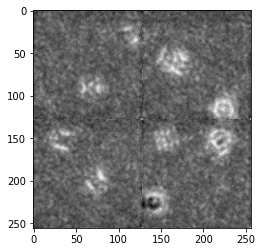

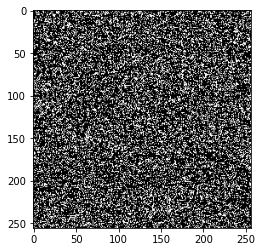

In [22]:
print(all_recon_img.shape)
Num = random.randint(0,all_recon_img.shape[0])
plt.imshow(all_recon_img[Num], cmap='gray')
print('current slice:', Num)

plt.figure();plt.imshow(Y_test_label[Num], cmap='gray')